In [1]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #разделение выборки

### Анализ требований

Знакомство с данными

In [2]:
data = pd.read_csv('data/insurance.csv')
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Итак, набор данных содержит следующие столбцы:

- age — возраст страхователя;
- sex — пол;
- bmi — индекс массы тела, в идеале — от 18.5 до 24.9;
- children — количество детей, охваченных медицинской страховкой;
- smoker — является ли человек курящим;
- region — район проживания в США (северо-восток, юго-восток, северо-запад, юго-запад);
- charges (целевой признак) — индивидуальные медицинские расходы, оплачиваемые медицинской страховкой.

In [3]:
# Размер таблицы:
print(data.shape)

(1338, 7)


In [4]:
# Выведем информацию о пропусках, так как наличие пропусков не позволит нам построить модель линейной регрессии:

display(data.isnull().sum())

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [5]:
# Посмотрим на типы данных:

display(data.dtypes)

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

Наши данные содержат несколько типов признаков:

- age, bmi, children — числовые признаки;
- sex, smoker — бинарные категориальные переменные (две категории);
- region — множественные категориальные переменные (несколько категорий);
- charges — числовой целевой признак.

## <center> Итерация №1
На первой итерации мы должны прийти к выводу - решаема ли задача. Может ли модель получить базовое качество (baseline). Для этого мы проводим небольшое исследование данных, базовую предобработку и строим простую модель, без подбора параметров.

### Исследование данных

In [6]:
data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [7]:
data.describe(include='object')

,sex,smoker,region
count,1338,1338,1338
unique,2,2,4
top,male,no,southeast
freq,676,1064,364


In [8]:
#Создаем копию данных для облегчения работы с изменениями в таблице
temp_data = data.copy()

In [9]:
#выделяем имена числовых признаков в виде списка для удобства дальнейшей работы
types = temp_data.dtypes
num_features = list(types[(types != 'object')].index)
num_features

['age', 'bmi', 'children', 'charges']

Для каждого числового признака построим гистограмму признаки и диаграмму рассеяния, иллюстрирующую зависимость целевого признака от каждого из факторов. Дополнительно поверх диаграммы рассеяния построим уравнение линейной регрессии.

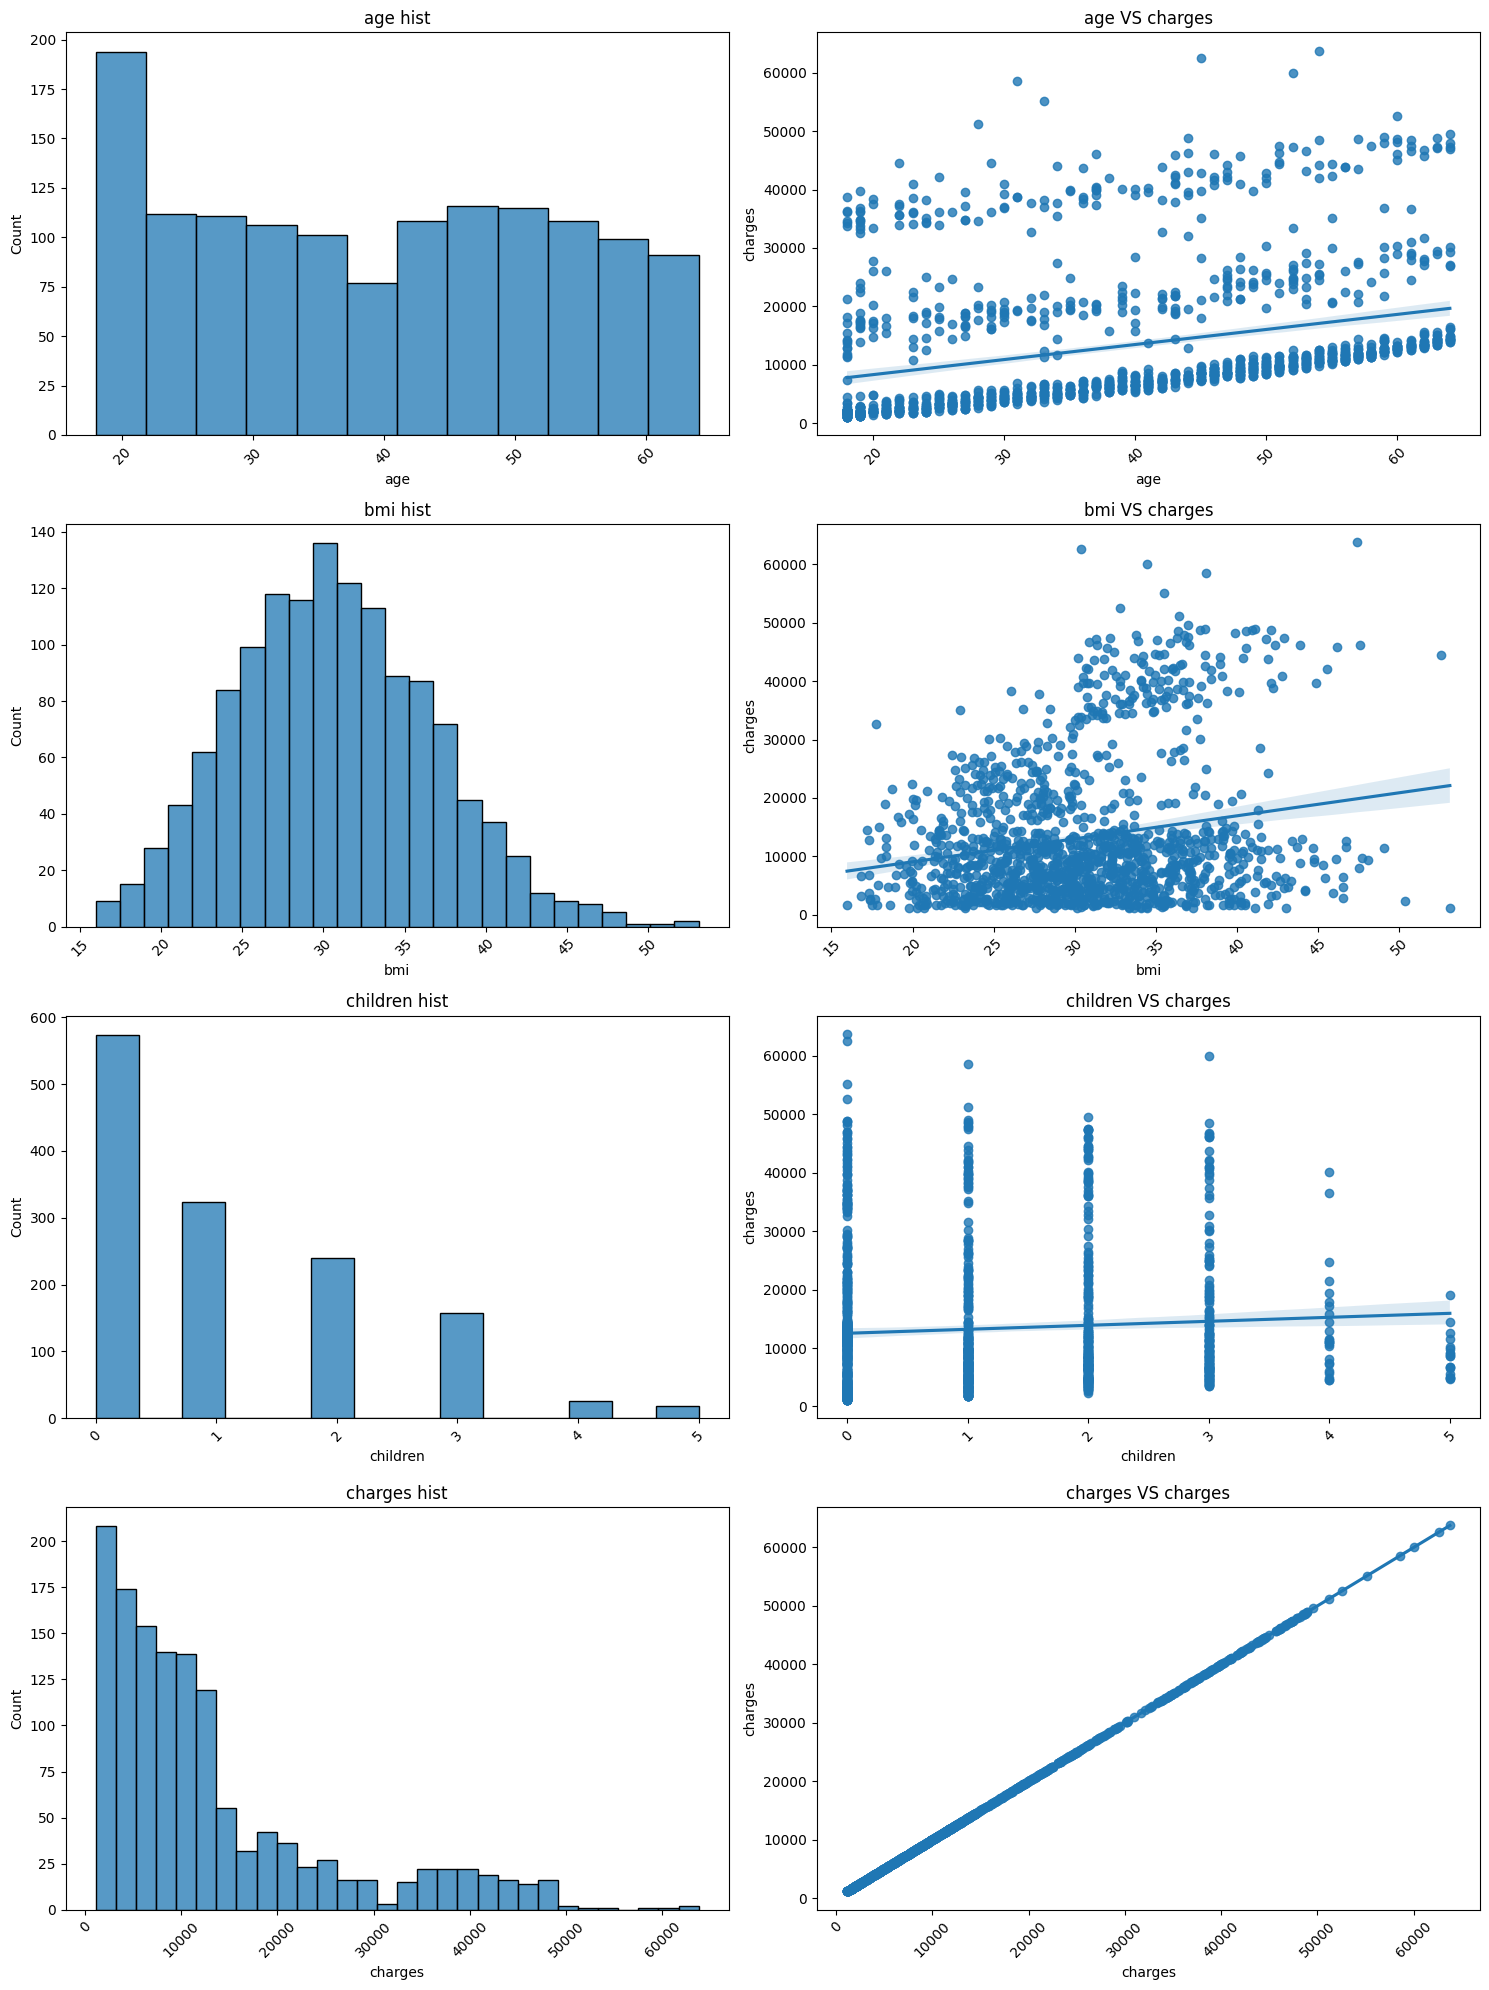

In [11]:
n = len(num_features) #количество числовых признаков
fig, axes = plt.subplots(n, 2, figsize=(15, 20)) # фигура + n х 2 координатных плоскостей
#Создаем цикл для всех признаков из списка числовых признаков
for i, feature in enumerate(num_features): #i- индекс, feature - название признака в таблице
    #Строим гистограмму распределения признака 
    histplot = sns.histplot(data=temp_data, x=feature, ax=axes[i][0])
    #Добавляем подпись графику
    histplot.set_title('{} hist'.format(feature))
    #Добавляем поворот отметок на оси абсцисс
    histplot.xaxis.set_tick_params(rotation=45)
    #Строим диаграмму рассеяния + линейную регрессию
    regplot = sns.regplot(data=temp_data, x=feature, y='charges', ax=axes[i][1])
    #Добавляем подпись графику
    regplot.set_title('{} VS charges'.format(feature));
    #Добавляем поворот отметок на оси абсцисс
    regplot.xaxis.set_tick_params(rotation=45)
plt.tight_layout() #выравнивание графиков

Строим тепловую карту для корреляционной матрицы, чтобы оценить мультиколлинеарную зависимость и линейную взаимосвязь между факторами и целевым признаком 

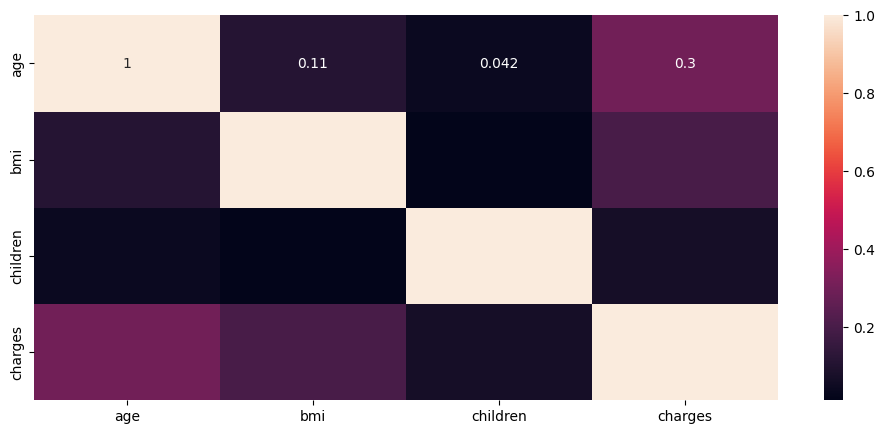

In [14]:
#строим тепловую карту корреляций
fig = plt.figure(figsize=(12, 5))
sns.heatmap(data[num_features].corr(), annot=True);

### Подготовка данных

Мы знаем, что модель линейной регрессии не умеет работать с категориальными признаками, поэтому категории необходимо перекодировать.

Кодировку будем совершать по следующему принципу:

- smoker — переведём в бинарные значения (0 — некурящий, 1 — курящий);
- sex — аналогично (0 — female, 1 — male);
- region — используем OneHot-кодирование (воспользуемся функцией get_dummies).

In [21]:
#кодируем бинарные категориальные признаки
data['smoker'] = data['smoker'].apply(lambda x: 0 if x == 'no' else 1)
data['sex'] = data['sex'].apply(lambda x: 0 if x == 'female' else 1)
#оставшиеся категориальные признаки кодируем с помощью OneHot
data = pd.get_dummies(data)
data.head()

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,False,False,False,True
1,18,1,33.770,1,0,1725.55230,False,False,True,False
2,28,1,33.000,3,0,4449.46200,False,False,True,False
3,33,1,22.705,0,0,21984.47061,False,True,False,False
4,32,1,28.880,0,0,3866.85520,False,True,False,False


In [22]:
# Выделим факторы и целевой признак в отдельные таблицы:

features = data.drop('charges', axis=1).columns
X, y = data[features], data['charges']

In [23]:
#Создаем тренировочную и тестовую выборки с помощью train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, #таблица с наблюдениями и столбец с правильным ответами
    test_size=0.2, #размер тестовой выборки
    random_state=42 #число отвечающее за генерацию случайных чисел
)
#Выводим размеры полученных выборок
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1070, 9)
Test shape: (268, 9)


### Моделирование + Оценка модели

Заранее создадим функцию, которая будет расчитывать метрики:

1. MAE - средняя абсолютная ошибка (целевая метрика)
2. MAPE - средняя абсолютная ошибка в процентах 
3. $R^2$ - коэффициент детерминации 

In [24]:
def print_metrics(y_train, y_train_predict, y_test, y_test_predict):
    print('Train R^2: {:.3f}'.format(metrics.r2_score(y_train, y_train_predict)))
    print('Train MAE: {:.3f}'.format(metrics.mean_absolute_error(y_train, y_train_predict)))
    print('Train MAPE: {:.3f}'.format(metrics.mean_absolute_percentage_error(y_train, y_train_predict)*100))
    print('\n')
    print('Test R^2: {:.3f}'.format(metrics.r2_score(y_test, y_test_predict)))
    print('Test MAE: {:.3f}'.format(metrics.mean_absolute_error(y_test, y_test_predict)))
    print('Train MAPE: {:.3f}'.format(metrics.mean_absolute_percentage_error(y_test, y_test_predict)*100))

**Модель линейной регрессии:**

Модель линейной регрессии имеет следующий вид:
$$\widehat{y_i}= w_0+\sum_{j=0}^m w_j x_{ij}$$
где $x_{ij}$ — объект из $i$-ой строки и $j$-ого столбца из таблицы объектов-признак $X$, $y_i$ — правильный ответ, соответствующий $x_{i}$, $\omega$ — параметры линейной регрессии

Для поиска параметров модели используется схема минизации эмпиричного риска - ищутся такие параметры $\omega$, при которых функция ошибки $L(\omega)$ была бы минимальна. 

В качестве функции потерь используем MSE - средний квадрат ошибки.

$$L(\omega) = MSE = \frac{1}{n} * \sum_{i=1}^{n}{(y_i - \widehat{y_i})^2} \Rightarrow min_\omega $$

**Аналитическое решение: метод наименьших квадратов (OLS):**

$$\omega=(X^TX)^{-1}X^Ty$$

В библиотеке sklearn линейная регрессия с поиском параметров по OLS реализована в классе LinearRegression модуля linear_model. 

Методы:
* fit() - подгонка параметров по OLS (обучение модели)
* predict() - предсказание (подстановка наблюдения $x_i$ в модель и получение ответа для каждого наблюдения)

Атрибуты:
* coef_ - найденные с помощью OLS коэффициенты $\omega_1, \omega_2,$ ...,$ \omega_m$ (в виде вектора)
* intercept_ - свободный член $\omega_0$

In [29]:
#Инициализируем объект класса линейная регрессия
lr = linear_model.LinearRegression()
#Обучаем модель - ищем параметры
lr.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)
#Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)
print('___')
print(np.round(lr.intercept_, 2))

Train R^2: 0.742
Train MAE: 4208.235
Train MAPE: 42.203


Test R^2: 0.784
Test MAE: 4181.194
Train MAPE: 46.888
___
-12390.8


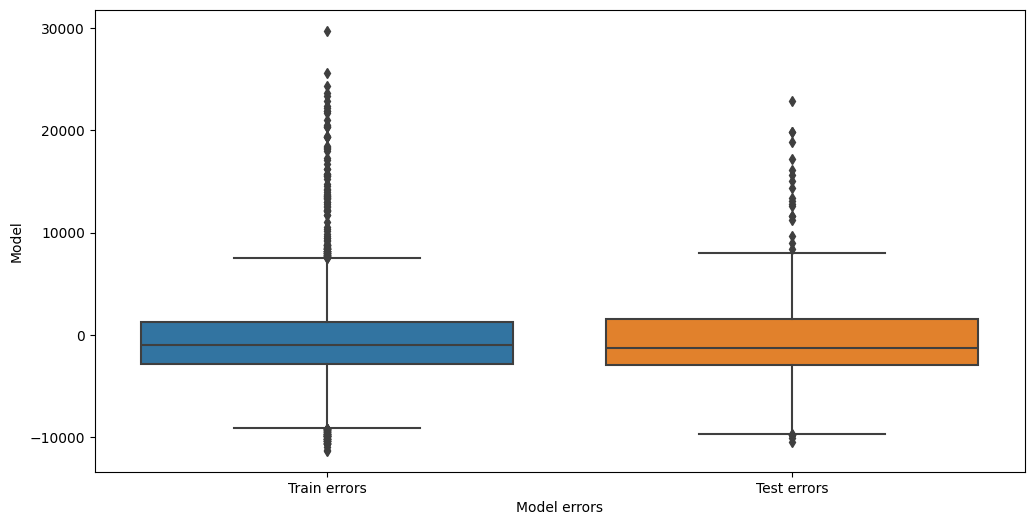

In [30]:
#Визуализируем ошибки
fig, ax = plt.subplots(figsize=(12, 6)) #фигура+координатная плоскость
#Ошибки модели на тренировочной выборке 
y_train_errors = y_train - y_train_pred
#Ошибки модели на тестовой выборке
y_test_errors = y_test - y_test_pred
#Для удобства визуализации составим DataFrame из ошибок
predict_df = pd.DataFrame(
    {'Train errors': y_train_errors, 
     'Test errors': y_test_errors
    }
)
#Строим boxplot для ошибок
sns.boxplot(data=predict_df, ax=ax)
ax.set_xlabel('Model errors') #название оси абсцисс
ax.set_ylabel('Model'); #название оси ординат

In [31]:
#Создаем объект для min-max нормализации
scaler = preprocessing.MinMaxScaler()
#Вычисляем параметры для нормализации - min и max для каждого столбца
scaler.fit(X_train)
#Производим преобразование для каждой из выборок
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Создаем объект для генерации полиномиальных признаков степени 2
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
#Вычисляем параметры генерации - результирующее количество признак
poly.fit(X_train_scaled)
#Производим преобразование для каждой из выборок
X_train_scaled_poly = poly.transform(X_train_scaled)
X_test_scaled_poly = poly.transform(X_test_scaled)

print('Train shape: {}'.format(X_train_scaled_poly.shape))
print('Test shape: {}'.format(X_test_scaled_poly.shape))

Train shape: (1070, 54)
Test shape: (268, 54)


In [37]:
lr_poly = linear_model.LinearRegression()
lr_poly.fit(X_train_scaled_poly, y_train)

y_train_pred = lr_poly.predict(X_train_scaled_poly)
y_test_pred = lr_poly.predict(X_test_scaled_poly)

print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.842
Train MAE: 2924.936
Train MAPE: 30.008


Test R^2: 0.866
Test MAE: 2766.588
Train MAPE: 30.944


In [38]:
print(lr_poly.coef_)

[-4.44086718e+16  1.03241367e+17  3.93148732e+14 -1.35827371e+14
 -4.54647529e+14 -4.40523872e+16 -2.87357345e+16 -3.09303781e+16
 -2.20967116e+16  8.35200000e+03  8.82000000e+02  1.05200000e+03
 -1.67800000e+03  1.72000000e+02  4.44086718e+16  4.44086718e+16
  4.44086718e+16  4.44086718e+16 -8.17850273e+16  6.73000000e+02
 -1.26425000e+03  2.70750000e+02 -2.14563400e+16 -2.14563400e+16
 -2.14563400e+16 -2.14563400e+16 -9.65518750e+03  1.58506250e+03
  5.48798750e+04 -3.93148732e+14 -3.93148732e+14 -3.93148732e+14
 -3.93148732e+14 -2.01800000e+03 -2.22600000e+03  1.35827371e+14
  1.35827371e+14  1.35827371e+14  1.35827371e+14  8.29406920e+14
 -3.74759391e+14 -3.74759391e+14 -3.74759391e+14 -3.74759391e+14
 -1.90001225e+15  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.72166649e+16  0.00000000e+00  0.00000000e+00 -1.50220214e+16
  0.00000000e+00 -2.38556879e+16]


**Линейная регрессия с L2-регуляризацией**

L2-регуляризация добавляет к функции ошибки дополнительное слагаемое, которое вносит смещение в обучение модели. Слагаемое - сумма квадратов коэффициентов модели.

$$L(\omega) = MSE + \alpha \sum_{j=1}^{m}{\omega_j^2}$$

$\alpha$ - коэффициент регуляризации, чем он выше, тем большее смещение вносится в модель (тем сильнее штраф за переобучение)

В библиотеке sklearn линейная регрессия с L2-регуляризацией (гребневая регрессия) реализована в классе Ridge модуля linear_model. 

Методы:
* fit() - подгонка параметров по методу координатного спуска - безпроизводный аналов градиентного спуска (обучение модели)
* predict() - предсказание (подстановка наблюдения $x_i$ в модель и получение ответа для каждого наблюдения)

Атрибуты:
* coef_ - найденные коэффициенты $\omega_1, \omega_2,$ ...,$ \omega_m$ (в виде вектора)
* intercept_ - свободный член $\omega_0$

In [43]:
#Инициализируем объект класса линейная регрессия с L2-регуляризацией 
ridge_lr_poly = linear_model.Lasso()
#Обучаем модель предсказывать логарифм целевого признака
ridge_lr_poly.fit(X_train_scaled_poly, y_train)
#Делаем предсказание для каждой из выборок
#Если обучили на логарифме, то от результата необходимо взять обратную функцию - экспоненту
y_train_pred = ridge_lr_poly.predict(X_train_scaled_poly)
y_test_pred = ridge_lr_poly.predict(X_test_scaled_poly)
#Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)
print('___')
print(lasso_lr_poly.coef_)

Train R^2: 0.842
Train MAE: 2889.297
Train MAPE: 29.368


Test R^2: 0.867
Test MAE: 2717.820
Train MAPE: 30.033
___
[ 3254.29444013  -497.77667434  5082.44296811  4579.96903719
 11174.5885881     92.27997327  -474.0824118    585.76537158
  -243.94757338  8291.3159849    776.44311147   834.79828593
 -1211.25190072   133.7834509  -1044.725423      -0.
  1169.28596708  1614.02590931    -0.           511.03215486
 -1132.38078219   266.01794461 -1221.18415878     0.
   239.00186822  -577.34015094 -8185.15426742  1294.30664583
 54733.92609325  3582.81956575  2403.95450092  -968.57471909
    -0.         -1670.63577613 -2056.02514315  1943.04187366
  1954.4503939      0.         -1061.93641958 -8575.11156654
    -0.          -592.75085202  -851.52193562  1359.94923273
   723.55006857     0.             0.             0.
    -0.             0.             0.             0.
     0.            -0.        ]


c:\Users\spbda\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.292e+09, tolerance: 1.544e+07
  model = cd_fast.enet_coordinate_descent(


In [46]:
#Инициализируем объект класса линейная регрессия с L2-регуляризацией 
ridge_lr_poly = linear_model.Ridge()
#Обучаем модель предсказывать логарифм целевого признака
ridge_lr_poly.fit(X_train_scaled_poly, y_train)
#Делаем предсказание для каждой из выборок
#Если обучили на логарифме, то от результата необходимо взять обратную функцию - экспоненту
y_train_pred = ridge_lr_poly.predict(X_train_scaled_poly)
y_test_pred = ridge_lr_poly.predict(X_test_scaled_poly)
#Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.839
Train MAE: 2948.804
Train MAPE: 29.546


Test R^2: 0.863
Test MAE: 2860.555
Train MAPE: 31.380
